In [1]:
import numpy as np
import math

import torch
import quairkit as qkit
from quairkit import to_state, Hamiltonian
from quairkit.database import *
from quairkit.qinfo import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
ry(1+ 2 * np.pi)

tensor([[-0.8776+0.j,  0.4794+0.j],
        [-0.4794+0.j, -0.8776+0.j]])

In [3]:
cir = qkit.Circuit(2)
cir.ry(1, param=1 + 2 * np.pi)
cir.matrix

tensor([[-0.8776+0.j,  0.4794+0.j,  0.0000+0.j,  0.0000+0.j],
        [-0.4794+0.j, -0.8776+0.j,  0.0000+0.j,  0.0000+0.j],
        [ 0.0000+0.j,  0.0000+0.j, -0.8776+0.j,  0.4794+0.j],
        [ 0.0000+0.j,  0.0000+0.j, -0.4794+0.j, -0.8776+0.j]])

In [4]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from qsp import *
from qite import *

In [5]:
from math import sqrt
from scipy.stats import norm

def mean_and_error(n_pos: int, n_neg: int, confidence: float = 0.95):
    n = n_pos + n_neg
    if n <= 0:
        raise ValueError("n_pos + n_neg must be positive.")
    if not (0.0 < confidence < 1.0):
        raise ValueError("confidence must be in (0, 1).")

    mean = (n_pos - n_neg) / n
    se = sqrt(max(0.0, 1.0 - mean * mean) / n)  # guard against tiny negative due to rounding
    z = norm.ppf((1.0 + confidence) / 2.0)
    error = z * se
    return mean, error

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

font_family = 'STIXGeneral'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = font_family
plt.rcParams["font.size"] = 18

In [7]:
qkit.set_dtype('complex128')
revise_tol(1e-40)

## Experiment setting

prepare Hamiltonian

In [8]:
num_qubits = 5

H_init = afm_heisenberg(n=num_qubits)
H = normalize(H_init, factor=np.abs(H_init.coefficients).sum())  # normalize the Hamiltonian

In [9]:
eigvals, eigvecs = torch.linalg.eigh(H.matrix)

ground_state_energy = eigvals[0].item()
ground_state = to_state(eigvecs[:, 0])

print(f'ground state energy = {ground_state_energy}')

ground state energy = -0.7319715633294984


Prepare input state as the computational state with the smallest non-zero overlap with the ground state

In [10]:
small_index = torch.argmin(torch.where(torch.abs(eigvecs[:, 0]) > 1e-10, torch.abs(eigvecs[:, 0]), 1)).item()
phi_state = computational_state(index=small_index, system_dim=2 ** num_qubits)

gamma = torch.abs(phi_state.bra @ ground_state.ket).item()
print(f'The state overlap between input state and ground state is {gamma}')

The state overlap between input state and ground state is 0.04798860730154218


Prepare evolution operator

In [11]:
U = torch.matrix_exp(-1j * H.matrix)

## Compute data

In [12]:
list_tau = list(np.arange(50, 4, -3))

list_probability, list_E_hat_tau = [], []

In [13]:
def even_floor(x):
    num = math.floor(x)
    if num % 2 != 0:  # If the number is odd, add 1 to make it even
        num += 1
    return num

In [14]:
proj = nkron(zero_state(1).bra, eye(2 ** (num_qubits)))
input_state = nkron(zero_state(1), phi_state)

for tau in list_tau:
    deg = max(50, even_floor(0.056 * (tau**3) -4.47 * (tau**2) + 121.36 * tau - 500))
    guess_lambda = -ground_state_energy + 1 / tau

    list_theta, list_phi = qite.get_qpp_angle(guess_lambda=guess_lambda, tau=tau, deg=deg, learn=False)
    
    cir = qpp_cir(list_theta, list_phi, U)
    output_state = proj @ cir(input_state).ket
    state_norm = torch.linalg.norm(output_state).item()
    
    list_probability.append(state_norm**2)
    output_state = output_state / state_norm

    output_state = to_state(output_state)
    list_E_hat_tau.append((output_state.bra @ H.matrix @ output_state.ket).real.item())

Computations of angles for QPP are completed with mean error 0.00010911550910783301
Computations of angles for QPP are completed with mean error 0.00014662836796929698
Computations of angles for QPP are completed with mean error 0.00021816258262892204
Computations of angles for QPP are completed with mean error 0.00025861475414549177
Computations of angles for QPP are completed with mean error 0.0002511064968525489
Computations of angles for QPP are completed with mean error 0.0006999385977024625
Computations of angles for QPP are completed with mean error 0.00037703841284594656
Computations of angles for QPP are completed with mean error 0.0004273054647939598
Computations of angles for QPP are completed with mean error 0.00036808497943520717
Computations of angles for QPP are completed with mean error 0.00038348592198200694
Computations of angles for QPP are completed with mean error 0.000541873983158634
Computations of angles for QPP are completed with mean error 0.000868120081118082

We also provide saved data to save computation time.

In [15]:
# list_tau, list_E_hat_tau, list_probability = np.load('data/figure2a_data.npy')

## Plot

In [16]:
probability_lower_bound = 0.85**2 * np.exp(-2) * np.abs(gamma)**2

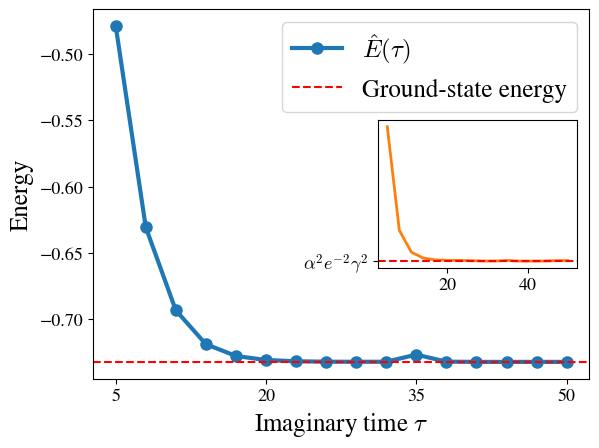

In [17]:
# Font size for labels and titles
fontsize = 18

# Plot the energy vs imaginary time
plt.plot(list_tau, list_E_hat_tau, 'o-', label=r'$\hat{E}(\tau)$', linewidth=3, markersize=8)

# Draw a horizontal line at the minimum eigenvalue (ground state energy)
plt.axhline(y=ground_state_energy, color='r', linestyle='--', label=r'Ground-state energy')

# Set axis labels
plt.xlabel(r'Imaginary time $\tau$', fontsize=fontsize)
plt.ylabel('Energy', fontsize=fontsize)

# Add legend to the main plot
plt.legend(loc='upper right', fontsize=fontsize)

plt.xticks([5, 20, 35, 50])
# Define custom y-ticks for better readability
# yticks0 = [-0.47, -0.49, -0.51]
# plt.yticks(yticks0, [f'${tick:.2f}$' for tick in yticks0])
plt.tick_params(labelsize=13)  # Increase tick label size

# Fix lower y-limit for consistency
# plt.ylim(-0.524, None)

# Create an inset axes for projection to zero state
ax_inset = inset_axes(plt.gca(), width="40%", height="40%", loc='center right')

# Plot the projection to the zero state over imaginary time
ax_inset.plot(list_tau, list_probability, '-', color='C1', linewidth=2)

# Draw a horizontal line indicating the theoretical bound
ax_inset.axhline(y=probability_lower_bound, color='r', linestyle='--')

# Set y-ticks for the inset plot
# Ensure that projection_bound is a scalar value
ax_inset.set_yticks([probability_lower_bound])
ax_inset.set_yticklabels([r'$\alpha^2 e^{-2} \gamma^2$'])

# Adjust font size of tick labels in the inset
ax_inset.tick_params(labelsize=13)

# Display the final figure
plt.show()

---

In [18]:
qkit.print_info()


---------VERSION---------
quairkit: 0.4.3
torch: 2.9.1+cu128
torch cuda: 12.8
numpy: 2.3.5
scipy: 1.16.3
matplotlib: 3.10.7
---------SYSTEM---------
Python version: 3.14.0
OS: Linux
OS version: #88-Ubuntu SMP PREEMPT_DYNAMIC Sat Oct 11 09:28:41 UTC 2025
---------DEVICE---------
CPU:  AMD EPYC 9554 64-Core Processor
GPU: (0) NVIDIA GeForce RTX 3090
     (0) NVIDIA GeForce RTX 3090
